In [385]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn import metrics
import warnings

from scipy.io import loadmat
from sklearn.model_selection import StratifiedGroupKFold, KFold
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, recall_score

# Keras imports
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import sparse_categorical_crossentropy
from keras import metrics



In [291]:
# Reshape the dataset from 1D to 2D
data = loadmat('USPS_all.mat')
X = data['fea']
Y = data['gnd']

X_2D = []

for i in range(len(X)):
    X_2D.append(X[i].reshape(16, 16))

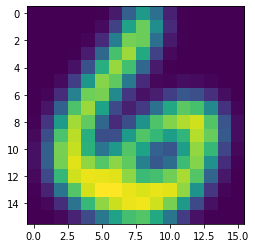

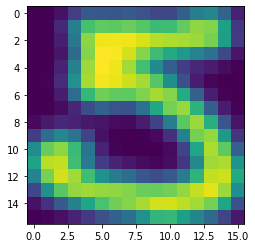

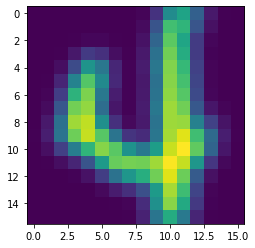

In [292]:
# Check the first 3 images
for i in range(3):
    plt.imshow(X_2D[i])
    plt.show()
    

In [293]:
# Check the shape for each array
print(f'X: {np.shape(X)}\nY: {np.shape(Y)}\nX_2D: {np.shape(X_2D)}')

X: (9298, 256)
Y: (9298, 1)
X_2D: (9298, 16, 16)


In [294]:
# Reshape from 2D to 3D for the Convol 2D
train_X = np.reshape(X_2D, (-1, 16, 16, 1))
print(np.shape(train_X))
train_X = train_X.astype('float')
Y = Y.astype('float')

(9298, 16, 16, 1)


In [325]:
# Defining batch size, epochs, classes
batch_size = 64
epochs = 20
num_classes = 10

# The model we are creating will be a CNN model
def create_model(activation='relu', neurons=32, hidden_layers=1, optimizer='adam', learn_rate=0.01, init_mode='uniform', dropout_rate=0.0, bias_initializer='zeros'):
    model = Sequential()
    model.add(Conv2D(neurons, kernel_size=(2,2), activation=activation, input_shape=(16,16,1), padding='same', bias_initializer=bias_initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Flatten())
    for i in range(hidden_layers):
        model.add(Dense(neurons, activation=activation, bias_initializer=bias_initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=sparse_categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

# Since we will be creating multiple models, we want a random seed to minimize reproducibility
seed = 3
np.random.seed(seed)

# Build the model
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [296]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_validate(model, train_X, Y, cv=kfold)

Epoch 1/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5943 - accuracy: 0.8346
Epoch 2/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2212 - accuracy: 0.9396
Epoch 3/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1819 - accuracy: 0.9507
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1474 - accuracy: 0.9603
Epoch 5/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1220 - accuracy: 0.9663
Epoch 6/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1000 - accuracy: 0.9736
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9774
Epoch 8/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0709 - accuracy: 0.9804
Epoch 9/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0599 - accuracy: 0.9847
Epoch 10/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0511 - accuracy: 0.9862

# Tuning Batch Size and Number of Epochs

In [299]:
# Tuning batch size and the number of epochs
batch_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
epochs = [10, 20, 30, 40, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_batch_epochs = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_batch_epochs.best_score_} using {grid_result_batch_epochs.best_params_}')

Epoch 1/10
744/744 [==============================] - 2s 2ms/step - loss: 0.3960 - accuracy: 0.8829
Epoch 2/10
744/744 [==============================] - 2s 2ms/step - loss: 0.1647 - accuracy: 0.9536
Epoch 3/10
744/744 [==============================] - 2s 2ms/step - loss: 0.1126 - accuracy: 0.9681
Epoch 4/10
744/744 [==============================] - 2s 2ms/step - loss: 0.0885 - accuracy: 0.9745
Epoch 5/10
744/744 [==============================] - 2s 2ms/step - loss: 0.0670 - accuracy: 0.9808
Epoch 6/10
744/744 [==============================] - 2s 2ms/step - loss: 0.0530 - accuracy: 0.9829
Epoch 7/10
744/744 [==============================] - 2s 2ms/step - loss: 0.0425 - accuracy: 0.9884
Epoch 8/10
744/744 [==============================] - 1s 2ms/step - loss: 0.0338 - accuracy: 0.9903
Epoch 9/10
744/744 [==============================] - 2s 2ms/step - loss: 0.0262 - accuracy: 0.9935
Epoch 10/10
186/186 [==============================] - 0s 770us/step - loss: 0.0773 - accuracy: 0.97

In [328]:
print(f'Best performance: {grid_result.best_score_} at {grid_result.best_params_}')

Best performance: 0.981824266910553 at {'batch_size': 20, 'epochs': 50}


# Tuning Training Optimizer

In [305]:
optimizer = ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_optimizer = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_optimizer.best_score_} at {grid_result_optimizer.best_params_}')

Epoch 1/20
117/117 [==============================] - 1s 5ms/step - loss: 1.9289 - accuracy: 0.3959: 0s - loss: 2.1811 - 
Epoch 2/20
117/117 [==============================] - 1s 5ms/step - loss: 1.0613 - accuracy: 0.7753
Epoch 3/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5730 - accuracy: 0.8723
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.4203 - accuracy: 0.8945
Epoch 5/20
117/117 [==============================] - 1s 6ms/step - loss: 0.3548 - accuracy: 0.9052
Epoch 6/20
117/117 [==============================] - 1s 5ms/step - loss: 0.3208 - accuracy: 0.9133
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2961 - accuracy: 0.9176
Epoch 8/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2797 - accuracy: 0.9222
Epoch 9/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2647 - accuracy: 0.9240
Epoch 10/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2

# Tuning Learning Rate

In [308]:
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv= kfold)
grid_results_learning_rate = grid.fit(train_X, Y)
print(f'Best performance: {grid_results_learning_rate.best_score_} using {grid_results_learning_rate.best_params_}')

Epoch 1/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5987 - accuracy: 0.8342
Epoch 2/20
117/117 [==============================] - 1s 6ms/step - loss: 0.2489 - accuracy: 0.9298
Epoch 3/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1950 - accuracy: 0.9458
Epoch 4/20
117/117 [==============================] - 1s 6ms/step - loss: 0.1557 - accuracy: 0.9563
Epoch 5/20
117/117 [==============================] - 1s 6ms/step - loss: 0.1320 - accuracy: 0.9636
Epoch 6/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1098 - accuracy: 0.9704
Epoch 7/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0894 - accuracy: 0.9747
Epoch 8/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0780 - accuracy: 0.9794
Epoch 9/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0686 - accuracy: 0.9810
Epoch 10/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0572 - accuracy: 0.9852

# Tuning Network Weight

In [310]:
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_weight = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_weight.best_score_} using {grid_result_weight.best_params_}')

Epoch 1/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5906 - accuracy: 0.8317
Epoch 2/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2277 - accuracy: 0.9368
Epoch 3/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1796 - accuracy: 0.9508
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1470 - accuracy: 0.9585
Epoch 5/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1171 - accuracy: 0.9685: 0s - loss: 0.1
Epoch 6/20
117/117 [==============================] - 1s 6ms/step - loss: 0.1013 - accuracy: 0.9720
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0887 - accuracy: 0.9757
Epoch 8/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9797
Epoch 9/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0604 - accuracy: 0.9836
Epoch 10/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0540 - 

# Neuron Activation Function

In [312]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_activation = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_activation.best_score_} using {grid_result_activation.best_params_}')

Epoch 1/20
117/117 [==============================] - 1s 11ms/step - loss: 2.2813 - accuracy: 0.1627
Epoch 2/20
117/117 [==============================] - 1s 11ms/step - loss: 2.1624 - accuracy: 0.2870
Epoch 3/20
117/117 [==============================] - 1s 11ms/step - loss: 2.0123 - accuracy: 0.3443
Epoch 4/20
117/117 [==============================] - 1s 11ms/step - loss: 1.9089 - accuracy: 0.3793
Epoch 5/20
117/117 [==============================] - 1s 12ms/step - loss: 1.8290 - accuracy: 0.3834
Epoch 6/20
117/117 [==============================] - 1s 11ms/step - loss: 1.7616 - accuracy: 0.3841
Epoch 7/20
117/117 [==============================] - 1s 12ms/step - loss: 1.7020 - accuracy: 0.3841
Epoch 8/20
117/117 [==============================] - 1s 12ms/step - loss: 1.6516 - accuracy: 0.3863
Epoch 9/20
117/117 [==============================] - 1s 12ms/step - loss: 1.6097 - accuracy: 0.3867
Epoch 10/20
117/117 [==============================] - 1s 12ms/step - loss: 1.5742 - accura

# Tuning Dropout Regularization

In [314]:
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_dropout = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_dropout.best_score_} using {grid_result_dropout.best_params_}')

Epoch 1/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5827 - accuracy: 0.8383
Epoch 2/20
117/117 [==============================] - 1s 5ms/step - loss: 0.2201 - accuracy: 0.9390
Epoch 3/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1581 - accuracy: 0.9570
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1275 - accuracy: 0.9645
Epoch 5/20
117/117 [==============================] - 1s 6ms/step - loss: 0.1036 - accuracy: 0.9703: 0s - loss: 0
Epoch 6/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0894 - accuracy: 0.9759
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0729 - accuracy: 0.9790
Epoch 8/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0668 - accuracy: 0.9817
Epoch 9/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0562 - accuracy: 0.9840
Epoch 10/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0448 - ac

# Tuning Bias on Different Layers

In [320]:
bias_initializer=bias_initializer = ['zeros', 'random_normal', 'random_uniform', 'truncated_normal' 'ones', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(bias_initializer=bias_initializer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_bias = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_bias.best_score_} using {grid_result_bias.best_params_}')

Epoch 1/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5601 - accuracy: 0.8457
Epoch 2/20
117/117 [==============================] - 1s 6ms/step - loss: 0.2126 - accuracy: 0.9430
Epoch 3/20
117/117 [==============================] - 1s 6ms/step - loss: 0.1655 - accuracy: 0.9552
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1317 - accuracy: 0.9653
Epoch 5/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1095 - accuracy: 0.9710
Epoch 6/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0924 - accuracy: 0.9753
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0741 - accuracy: 0.9785
Epoch 8/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0666 - accuracy: 0.9810
Epoch 9/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0569 - accuracy: 0.9848
Epoch 10/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0485 - accuracy: 0.9862

C:\Users\jhoon\miniconda3\envs\ANN\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jhoon\miniconda3\envs\ANN\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jhoon\miniconda3\envs\ANN\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\jhoon\miniconda3\envs\ANN\lib\site-packages\tensorflow\python\keras\wrappers\scikit_le

146/146 [==============================] - 1s 6ms/step - loss: 0.4846 - accuracy: 0.8645
Epoch 2/20
146/146 [==============================] - 1s 6ms/step - loss: 0.1963 - accuracy: 0.9446
Epoch 3/20
146/146 [==============================] - 1s 6ms/step - loss: 0.1393 - accuracy: 0.9627
Epoch 4/20
146/146 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9700
Epoch 5/20
146/146 [==============================] - 1s 5ms/step - loss: 0.0878 - accuracy: 0.9747
Epoch 6/20
146/146 [==============================] - 1s 6ms/step - loss: 0.0701 - accuracy: 0.9818
Epoch 7/20
146/146 [==============================] - 1s 6ms/step - loss: 0.0587 - accuracy: 0.9830
Epoch 8/20
146/146 [==============================] - 1s 6ms/step - loss: 0.0503 - accuracy: 0.9842
Epoch 9/20
146/146 [==============================] - 1s 6ms/step - loss: 0.0408 - accuracy: 0.9886
Epoch 10/20
146/146 [==============================] - 1s 5ms/step - loss: 0.0361 - accuracy: 0.9901
Epoch 11/2

# Number of Neuron on Each Hidden Layer

In [324]:
neurons = [1, 2, 4, 8, 16, 32, 64, 128]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_neuron = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_neuron.best_score_} using {grid_result_neuron.best_params_}')

Epoch 1/20
117/117 [==============================] - 0s 2ms/step - loss: 2.2925 - accuracy: 0.1523
Epoch 2/20
117/117 [==============================] - 0s 2ms/step - loss: 2.2553 - accuracy: 0.2229
Epoch 3/20
117/117 [==============================] - 0s 2ms/step - loss: 2.1814 - accuracy: 0.2459
Epoch 4/20
117/117 [==============================] - 0s 2ms/step - loss: 2.0685 - accuracy: 0.2901
Epoch 5/20
117/117 [==============================] - 0s 2ms/step - loss: 1.9973 - accuracy: 0.2970
Epoch 6/20
117/117 [==============================] - 0s 2ms/step - loss: 1.9539 - accuracy: 0.2985
Epoch 7/20
117/117 [==============================] - 0s 2ms/step - loss: 1.9170 - accuracy: 0.2985
Epoch 8/20
117/117 [==============================] - 0s 2ms/step - loss: 1.8830 - accuracy: 0.2991
Epoch 9/20
117/117 [==============================] - 0s 2ms/step - loss: 1.8533 - accuracy: 0.3041
Epoch 10/20
117/117 [==============================] - 0s 2ms/step - loss: 1.8272 - accuracy: 0.3083

# Number of Hidden Layers

In [326]:
hidden_layers = [1, 3, 5, 10]
param_grid = dict(hidden_layers=hidden_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result_layers = grid.fit(train_X, Y)
print(f'Best performance: {grid_result_layers.best_score_} using {grid_result_layers.best_params_}')

Epoch 1/20
117/117 [==============================] - 0s 4ms/step - loss: 0.9840 - accuracy: 0.6949
Epoch 2/20
117/117 [==============================] - 0s 4ms/step - loss: 0.3045 - accuracy: 0.9165
Epoch 3/20
117/117 [==============================] - 0s 4ms/step - loss: 0.2392 - accuracy: 0.9320
Epoch 4/20
117/117 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9453
Epoch 5/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.9507
Epoch 6/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1566 - accuracy: 0.9576
Epoch 7/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.9583
Epoch 8/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.9683
Epoch 9/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1141 - accuracy: 0.9703
Epoch 10/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1049 - accuracy: 0.9727

In [335]:
results = cross_val_predict(model, train_X, Y, cv=kfold)

Epoch 1/20
117/117 [==============================] - 0s 4ms/step - loss: 0.8462 - accuracy: 0.7693
Epoch 2/20
117/117 [==============================] - 1s 4ms/step - loss: 0.2744 - accuracy: 0.9246
Epoch 3/20
117/117 [==============================] - 0s 4ms/step - loss: 0.2128 - accuracy: 0.9433
Epoch 4/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1845 - accuracy: 0.9519
Epoch 5/20
117/117 [==============================] - 1s 4ms/step - loss: 0.1590 - accuracy: 0.9562
Epoch 6/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9620
Epoch 7/20
117/117 [==============================] - 0s 4ms/step - loss: 0.1257 - accuracy: 0.9671
Epoch 8/20
117/117 [==============================] - 1s 4ms/step - loss: 0.1081 - accuracy: 0.9730
Epoch 9/20
117/117 [==============================] - 1s 5ms/step - loss: 0.1002 - accuracy: 0.9731
Epoch 10/20
117/117 [==============================] - 1s 4ms/step - loss: 0.0874 - accuracy: 0.9770

In [338]:
f1score = f1_score(Y, results, average='weighted')

In [339]:
f1score

0.971499490592672

# Creating Model with all the Best Hyper-parameters

In [346]:
# Best performing batch and epoch sizes
batch_size = 20
epochs = 50

# Creating the optimized model
def create_optimized_model(activation='linear', neurons=128, hidden_layers=3, optimizer='RMSprop', learn_rate=0.3, init_mode='glorot_uniform', dropout_rate=0.6, bias_initializer='random_uniform'):
    model = Sequential()
    model.add(Conv2D(neurons, kernel_size=(2,2), activation=activation, input_shape=(16,16,1), padding='same', bias_initializer=bias_initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Flatten())
    for i in range(hidden_layers):
        model.add(Dense(neurons, activation=activation, bias_initializer=bias_initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=sparse_categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

model_optimized = KerasClassifier(build_fn=create_optimized_model, epochs=epochs, batch_size=batch_size)

In [348]:
result_optimized = cross_val_predict(model_optimized, train_X, Y, cv=2)
#cross_validate(model_optimized, train_X, Y, cv=kfold)

Epoch 1/50
233/233 [==============================] - 3s 12ms/step - loss: 0.4971 - accuracy: 0.8453
Epoch 2/50
233/233 [==============================] - 3s 12ms/step - loss: 0.1860 - accuracy: 0.9449
Epoch 3/50
233/233 [==============================] - 3s 13ms/step - loss: 0.1246 - accuracy: 0.9611
Epoch 4/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0964 - accuracy: 0.9701
Epoch 5/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0798 - accuracy: 0.9761
Epoch 6/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0645 - accuracy: 0.9802
Epoch 7/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0557 - accuracy: 0.9826
Epoch 8/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0510 - accuracy: 0.9821
Epoch 9/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0454 - accuracy: 0.9845
Epoch 10/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0452 - accura

## Getting the metric scores

Accuracy:  0.9689180468918047
F1 Score:  0.9688399964015666
Precision:  0.9689885899845015
Recall:  0.9689180468918047


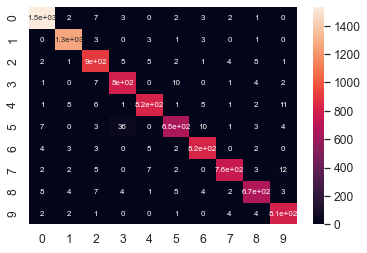

In [387]:
acc_score = accuracy_score(Y, result_optimized)
f1score = f1_score(Y, result_optimized, average='weighted')
prec_score = precision_score(Y, result_optimized, average='weighted')
recallscore = recall_score(Y, result_optimized, average='weighted')
confusion = confusion_matrix(Y, result_optimized)
#auc = roc_auc_score(Y, result_optimized, average='average', multi_class='ovr')


# Print them all!
print('Accuracy: ', acc_score)
print('F1 Score: ', f1score)
print('Precision: ', prec_score)
print('Recall: ', recallscore)
df_range = pd.DataFrame(confusion, range(10), range(10))
sn.set(font_scale=1.1)
sn.heatmap(df_range, annot=True, annot_kws={"size":8})
plt.show()
#print('Confusion matrix: \n', confusion)
#print('AUC Score: ', auc)